# Loading Libraries and Initialize

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

# Reading data from CSV file and filtering Apple stock price 

In [2]:
allData = pd.read_csv('Data//all_stocks_5yr.csv', index_col=['date'], parse_dates=['date'])
df = allData[allData['Name'] == 'AAPL']

# Triple Exponential Smoothing (TES) a.k.a. Holt-Winters
\begin{align}
& \ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})& \mbox{level} \\
& b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} & \mbox{trend} \\
& s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L} & \mbox{seasonal} \\
& \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}& \mbox{forecast}\\
\end{align}
- α is smoothing parameter where 0≤ α ≤1.
- β coefficient is a weight in the exponential smoothing where 0≤ β ≤1.
- γ is the smoothing factor for the seasonal component where 0≤ γ ≤1.
- TES is useful to understand the trend and intercept with seasonality.

https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm

https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3


## Initial Trend
For double exponential smoothing we simply used the first two points for the initial trend. With seasonal data we can do better than that, since we can observe many seasons and can extrapolate a better starting trend. The most common practice is to compute the average of trend averages across seasons.

In [3]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

## Initial Seasonal Components
The situation is even more complicated when it comes to initial values for the seasonal components. Briefly, we need to compute the average level for every observed season we have, divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons. 

In [4]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

## The Algorithm

In [5]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# Calculating Triple Exponential Smoothing

In [6]:
alpha = 0.5
beta = 0.1
gamma = 0.9
df['tes'] = triple_exponential_smoothing(df['close'], 30, alpha, beta, gamma, 0)
df.tail(10)

,open,high,low,close,volume,Name,tes
date,,,,,,,
2018-01-25,174.505,174.9500,170.5300,171.11,41529004,AAPL,170.680974
2018-01-26,172.000,172.0000,170.0600,171.51,39143011,AAPL,170.384861
2018-01-29,170.160,170.1600,167.0700,167.96,50640406,AAPL,166.467871
2018-01-30,165.525,167.3700,164.7000,166.97,46048185,AAPL,165.078326
2018-01-31,166.870,168.4417,166.5000,167.43,32478930,AAPL,165.389296
2018-02-01,167.165,168.6200,166.7600,167.78,47230787,AAPL,165.738904
2018-02-02,166.000,166.8000,160.1000,160.50,86593825,AAPL,158.516789
2018-02-05,159.100,163.8800,156.0000,156.49,72738522,AAPL,154.370765
2018-02-06,154.830,163.7200,154.0000,163.03,68243838,AAPL,160.762534


# Visualizing All Data

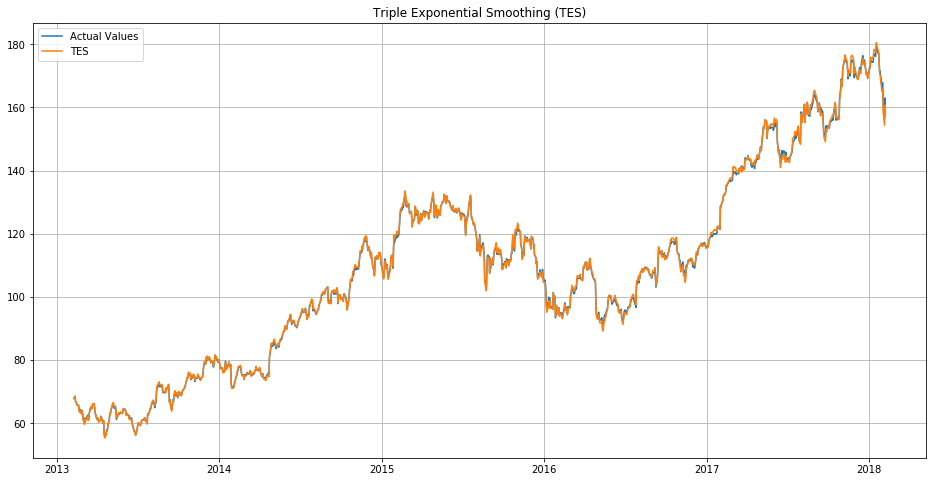

In [7]:
plt.figure(figsize=(16,8))
plt.title('Triple Exponential Smoothing (TES)')

plt.plot(df['close'], label='Actual Values')
plt.plot(df['tes'], label='TES')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Visualizing Last 200 Days

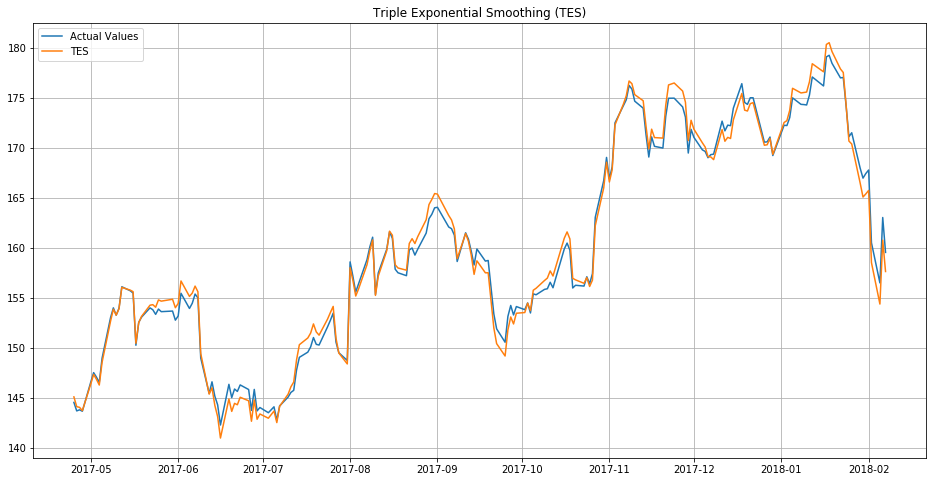

In [8]:
df = df[-200:]

plt.figure(figsize=(16,8))
plt.title('Triple Exponential Smoothing (TES)')

plt.plot(df['close'], label='Actual Values')
plt.plot(df['tes'], label='TES')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()